In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
text = open('shakespeare.txt', 'r').read()
text = text.lower()
chars = sorted(list(set(text)))

In [3]:
stoi = {s: i for i,s in enumerate(chars)}
itos = {i: s for i,s in enumerate(chars)}
vsize = len(chars)
vsize

39

In [4]:
print(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
data = torch.tensor([stoi[ch] for ch in text])
len(data)

1115394

In [6]:
print(''.join(itos[i.item()] for i in data[0:300]))

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us


In [146]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(LSTM, self).__init__()
        
        self.hsize = hidden_size
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.i_x = nn.Linear(input_size, hidden_size)
        self.i_h = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.f_x = nn.Linear(input_size, hidden_size)
        self.f_h = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.o_x = nn.Linear(input_size, hidden_size)
        self.o_h = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.z_x = nn.Linear(input_size, hidden_size)
        self.z_h = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.proj = nn.Linear(hidden_size, out_size, bias=False)
        
    def forward(self, x, hc):
        hidden, cell = hc
        
        i = self.sigmoid(self.i_x(x) + self.i_h(hidden))
        f = self.sigmoid(self.f_x(x) + self.f_h(hidden))
        o = self.sigmoid(self.o_x(x) + self.o_h(hidden))
        z = self.tanh(self.z_x(x) + self.z_h(hidden))
        
        cell = f * cell + i * z
        hidden = self.tanh(cell) * o
        # project ouput
        output = self.proj(hidden)
        return output, (hidden, cell)
    
    def init_hidden(self):
        return torch.zeros(1, self.hsize, requires_grad=False), torch.zeros(1, self.hsize, requires_grad=False)

In [151]:
torch.manual_seed(1337)

In [152]:
# hyperparams
hidden_size = 100
iters = 50_000
lr = 0.01

# tracking and validation vars
print_every_N = 1000
seqlen = 50
losses = []
correct = 0

# initialize LSTM
lstm = LSTM(vsize, hidden_size, vsize)

# optimizer
optim = torch.optim.Adam(lstm.parameters(), lr=lr)

# random sampling from data
idxs = torch.randint(0, 1_000_000, size=(iters,))

for i, idx in enumerate(idxs):
    # reset optimizer and hidden/cell states
    optim.zero_grad()
    hc = lstm.init_hidden()
    
    # Get x, y; encode, prepare output tensor
    x = data[idx : idx+seqlen]
    y = data[idx+1 : idx+seqlen+1]
    x_enc = F.one_hot(x, vsize).view(seqlen, 1, vsize).float()
    out = torch.zeros((seqlen, vsize))
    
    # Forward propagation
    for j, ch in enumerate(x_enc):
        out[j], hc = lstm.forward(ch, hc)
        
    loss = F.cross_entropy(out, y)
    
    # Backpropagation
    loss.backward()
    optim.step()
    
    # Accuracy check
    choice = torch.argmax(out[-1])
    if choice == y[-1]:
        correct += 1
        
    # loss and accuracy tracking
    if i % print_every_N == 0:
        losses.append(loss.item())
        print(f"i: {i} \tLoss: {loss}")
        
        if i > 0:
            print(f"Accuracy: {correct / print_every_N}")
            correct = 0
        
    
    
    

i: 0 	Loss: 3.6721181869506836
i: 1000 	Loss: 2.2001471519470215
Accuracy: 0.346
i: 2000 	Loss: 2.0892083644866943
Accuracy: 0.397
i: 3000 	Loss: 1.7285085916519165
Accuracy: 0.439
i: 4000 	Loss: 1.715765118598938
Accuracy: 0.487
i: 5000 	Loss: 1.8033556938171387
Accuracy: 0.467
i: 6000 	Loss: 1.5464808940887451
Accuracy: 0.477
i: 7000 	Loss: 2.1345925331115723
Accuracy: 0.494
i: 8000 	Loss: 2.041067123413086
Accuracy: 0.48
i: 9000 	Loss: 1.8424890041351318
Accuracy: 0.523
i: 10000 	Loss: 1.5898349285125732
Accuracy: 0.498
i: 11000 	Loss: 1.6855829954147339
Accuracy: 0.5
i: 12000 	Loss: 1.7852307558059692
Accuracy: 0.491
i: 13000 	Loss: 1.9361927509307861
Accuracy: 0.498
i: 14000 	Loss: 1.4912225008010864
Accuracy: 0.498
i: 15000 	Loss: 1.4771208763122559
Accuracy: 0.504
i: 16000 	Loss: 1.7489933967590332
Accuracy: 0.529
i: 17000 	Loss: 1.319865107536316
Accuracy: 0.505
i: 18000 	Loss: 1.3566484451293945
Accuracy: 0.532
i: 19000 	Loss: 1.8048787117004395
Accuracy: 0.503
i: 20000 	Loss:

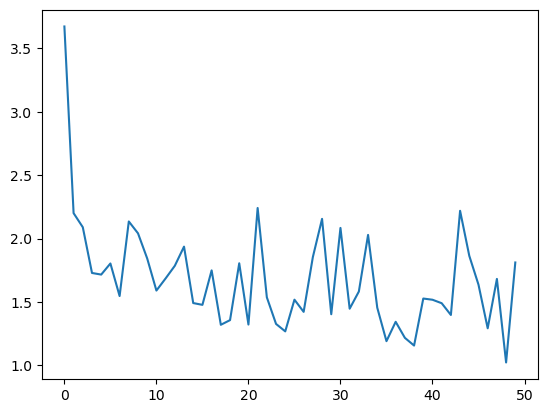

In [117]:
plt.plot(losses)
plt.show()


In [156]:
with torch.no_grad():
    size = 2000
    
    gen = torch.tensor([8] * 2000, dtype=int)

    i = 50
    
    while i < size:
        hc = L1.init_hidden()
        context = F.one_hot(gen[i-50 : i], vsize).view( 50 , vsize).float()

        out = torch.zeros((50, vsize))
        # Forward propagation
        for j, ch in enumerate(context):
            out[j], hc = L1.forward(ch, hc)
        
        distr = torch.distributions.Categorical(probs=F.softmax(out[-1], dim=0))
        choice = distr.sample()

        gen[i] = choice
        i += 1

In [157]:
print(''.join([itos[i.item()] for i in gen]))

..................................................

valtin:
whilst thy mother this away's will 'less and be by
god's lean to feat's in the
wrinh and looks 'less have the slucking greeting ere and say,
that, marry this degened him day away.

cominius:
this had now and srown clarence midsat you have be more pardons hereford.
have furtesh this his favelts
i'd bend off though gland souncty's honour
must let my fault thy prove me
bo
'-came in the blood a
but this clokent night; on me
alsice and dost lius cudssice:
i enemity henry vi:
afterm, be go be the worthy prisonea?

clarence:
horted he is ry chrishe for breeds are was unto what thou
chowing a goods i entreer aidle from
whoms to peerticn larder'd to stoused madam fear
be, give not honour'd bough, thereaven
whose foely yes queld up this of oulse
i will not while me. that now i am make him.

cleomits;
and debence with things denay my cononicsup senan'd,
to with the nature, and that hark:
i stay, since shows of glassic of this fair,
to st